## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

# Get the DM halo mass (and the number of DM particles for sample).
commah_output = commah.run('Planck13', zi=0, Mi=1e8, z=0)
Mz = commah_output['Mz'][0,0]*Msun
num_DM = math.floor(Mz / DM_mass)

# Get the parameters of the halo.
c_200 = commah_output['c'][0,0]
# R_200 = 

ic(commah_output)

ic(f'{Mz/Msun:.2e}')
ic(f'{c_200:.2e}')

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir, origin_offset=0.):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('Planck13', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian DM_coords.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z)) + origin_offset

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)


# Generate 2 NFW halos: 10^12 host halo and 10^8 subhalo some offset away.
subhalo_offset = np.array([0, 40, 8])*kpc
with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir),
        repeat(subhalo_offset)

    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Load, transform and plot simulation outputs.

(5, 768, 100)


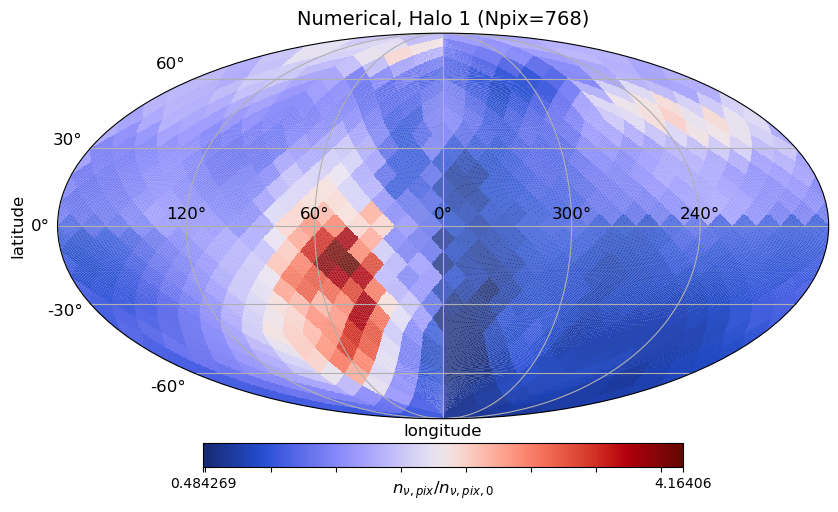

(5, 768, 100)


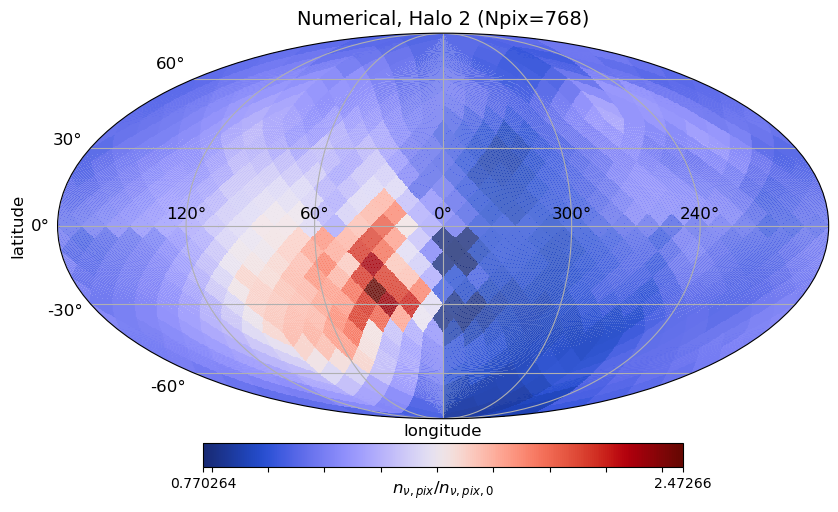

(5, 768, 100)


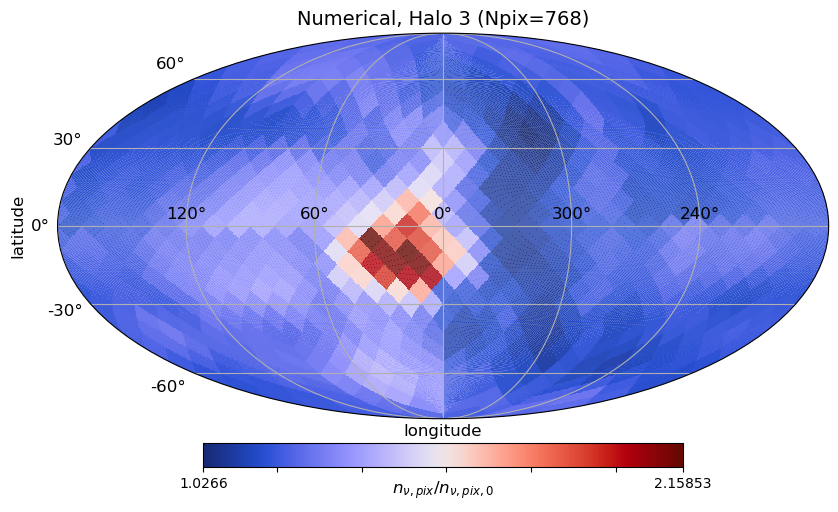

(5, 768, 100)


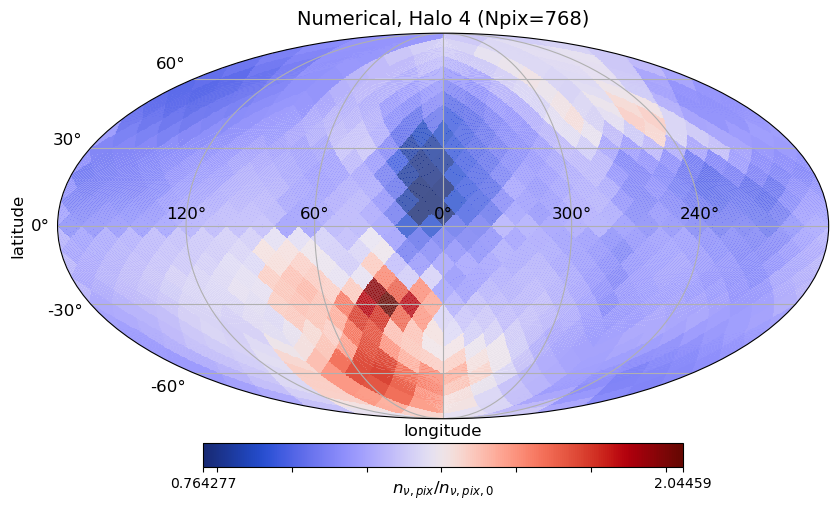

(5, 768, 100)


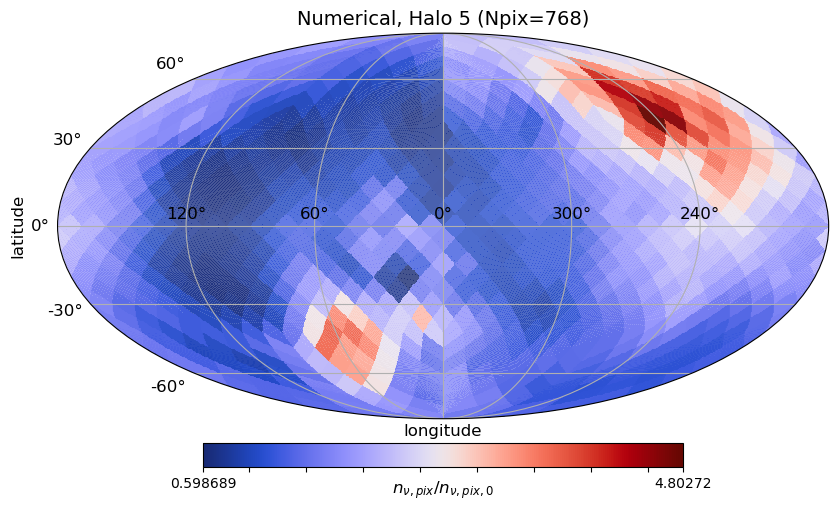

In [2]:
from shared.preface import *
from shared.shared_functions import *
from shared.plot_class import analyze_simulation_outputs
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde

class analyze_simulation_outputs_test(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical_single_halos.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1):
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )


    def plot_all_sky_map(self, nu_mass_eV, sim_method, halo=None):

        savefig_args = dict(
            bbox_inches='tight'
        )
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        # Automatic.
        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[:,nu_mass_idx]
            etas_nu = dens_nu/N0_pix

            healpix_map = etas_nu

            hp.newvisufunc.projview(
                healpix_map,
                coord=['G'],
                # title=f'Analytical (Npix={Npix}, {nu_mass_eV}eV)',
                # unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                # graticule=True,
                # graticule_labels=True,
                # xlabel="longitude",
                # ylabel="latitude",
                # cb_orientation="horizontal",
                # projection_type="mollweide",
                flip='astro',
                # cbar_ticks=[],
                # show_tickmarkers=True,
            )

            plt.savefig(
                f'{self.fig_dir}/all_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map

        if sim_method == 'numerical':

            halo_params = np.load(
                glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
            )
            # Mvir = halo_params[halo-1,1]
            
            # Initial pixel array.
            print(self.number_densities_numerical_all_sky.shape)
            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu/N0_pix
            healpix_map = etas_nu[halo-1,:]
            # healpix_map2 = etas_nu[halo+1,:]

            # Rotate healpix map.
            

            hp.newvisufunc.projview(
                healpix_map,
                coord=['G'],
                title=f'Numerical, Halo {halo} (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                # cmap=cc.cm.CET_L19,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro',
                # cbar_ticks=[],
                show_tickmarkers=True,
                # norm='log',
                # min=0.5,
                # max=3.5,
                alpha=0.8
            )

            '''
            nr = 10
            # x = np.deg2rad(np.random.randint(0, 360, size=nr))
            # y = np.deg2rad(np.random.randint(-90, 90, size=nr))

            x = np.random.normal(size=1000)
            y = x * 3 + np.random.normal(size=1000)

            # Calculate the point density
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)

            # Sort the points by density, s.t. densest points are plotted last
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]

            plt.scatter(x, y, c=z, alpha=0.1, cmap='Purples', s=80)
            # '''
            
            plt.savefig(
                f'{self.fig_dir}/all_sky_map_numerical_halo{halo}_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map


    def plot_neutrinos_inside_Rvir(self):

        #? evidence to show at what redshift clustering happens?
        
        # All positions and velocities across redshifts.
        pos = self.vectors_analytical[...,0:3]
        vel = self.vectors_analytical[...,3:6]

        # Radii and velocity magnitudes.
        rad = np.sqrt(np.sum(pos**2, axis=-1))
        mag = np.sqrt(np.sum(vel**2, axis=-1))
        ic(mag.shape)

        # Escape velocity.
        MW_esc = 550  # km/s
        esc_cond = (mag*(kpc/s)/(km/s) <= MW_esc)
        _, esc_num = np.unique(esc_cond, return_counts=True, axis=0)
        # esc = np.where()
        # zeds_esc_nr = [len(arr) for arr in esc]


# print(np.load(
#     'L025N752/DMONLY/SigmaConstant00/all_sky_low_res/halo_batch_1e+12.0_pm0.6Msun_params.npy'
# ))
# print(np.load(
#     'L025N752/DMONLY/SigmaConstant00/all_sky_high_res/halo_batch_1e+12.0_pm0.6Msun_params.npy'
# ))

# Analysis.plot_neutrinos_inside_Rvir()

'''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/spheres_high_res'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'spheres',
    shells=3
)
Analysis.plot_overdensity_band(plot_ylims=None)
# '''

# '''
sim_dir = f'L025N752/DMONLY/SigmaConstant00/all_sky_high_res_TEST'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)
Analysis = analyze_simulation_outputs_test(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)
halo_num = 5
for i in range(1,halo_num+1): 
    healpix_map = Analysis.plot_all_sky_map(
        nu_mass_eV=0.2, sim_method='numerical', halo=i
    )
# '''